In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings(
    "ignore", 
    message="All-NaN slice encountered", 
    category=RuntimeWarning
)

In [2]:
zo_opt_file = "ZO_opt.csv"
hybrid_file = "Hybrid.csv"
peft_file = "PEFT.csv"
mem_file = "Mem_usage.csv"

zo_opt_df = pd.read_csv(zo_opt_file).dropna(how='all')
hybrid_df = pd.read_csv(hybrid_file).dropna(how='all')
peft_df = pd.read_csv(peft_file).dropna(how='all')
mem_df = pd.read_csv(mem_file).dropna(how='all')

In [3]:
SMALL_MODELS = ("RoBERTa-Base", "RoBERTa-large", "RoBERTa-large ")
MEDIUM_MODELS = ("OPT-1.3B", "OPT-2.7B")
LARGE_MODELS = ("LLaMA-7b", "LLaMA2-7b", "LlaMA3-8b", "OPT-13B")

TASK_TYPE_TO_DATASET = {"Natural Language Inference": ("SNLI", "MNLI", "RTE", "CB"),
                        "Sentiment Analysis": ("SST-2", "SST-5"),
                        "Reading Comprehension/Question Answering": ("SQuAD", "MultiRC", "ReCoRD", "DROP", "BoolQ"),
                        "Commonsense & Causal Reasoning": ("COPA", "WSC"),
                        "Word Sense/Contextual Meaning": ["WiC"],
                        "Question Classification": ["TREC"]}

def get_dataset_type(dataset_name):
    for task_type, datasets in TASK_TYPE_TO_DATASET.items():
        if dataset_name in datasets:
            return task_type
    return "Unknown"

def get_model_size(model_name):
    if model_name in SMALL_MODELS:
        return "small"
    elif model_name in MEDIUM_MODELS:
        return "medium"
    elif model_name in LARGE_MODELS:
        return "large"
    else:
        return "unknown"

In [4]:
zo_opt_df['method_type'] = 'zo_opt'
hybrid_df['method_type'] = 'hybrid'
peft_df['method_type'] = 'peft'

combined_df = pd.concat([zo_opt_df, hybrid_df, peft_df], ignore_index=True)
combined_df['model_type'] = combined_df['Model'].apply(get_model_size)
combined_df = combined_df.map(lambda x: x * 100 if isinstance(x, (int, float)) and x < 1 else x)

In [5]:
def interpolate(combined_df, fix_elements, threshold=5):
    """
    Interpolate missing performance values by averaging available data while fixing certain elements.
        method A (with category A')
        fine-tuning model B (with model size B')
        on dataset C (with task type C')
    Fix some of subset of {A, A', B, B', C, C'} and take the avg
    If not enough data for a criteria (eg A), fix its ' (eg A') instead
    eg. Interpolating (x): HiZOO fine-tuning llama2-7b on the SST-2 dataset
        fix_elements = ("A", "B'", "C'")
        x = mean(HiZOO fine-tuning large model on sentiment analysis dataset)

    Parameters:
    - combined_df (pd.DataFrame): Merged DataFrame containing all method types.
    - fix_elements (tuple): Elements to fix during interpolation.
    - threshold (int, optional): Minimum number of available data points required to refine filtering. Default is 5.

    Returns:
    - pd.DataFrame: The DataFrame with interpolated missing values.
    """

    assert isinstance(zo_opt_df, pd.DataFrame) and isinstance(hybrid_df, pd.DataFrame) and isinstance(peft_df, pd.DataFrame)
    assert isinstance(fix_elements, list) and len(fix_elements) <= 6
    assert all([element in ("A", "A'", "B", "B'", "C", "C'") for element in fix_elements])

    META_INFO = ["Method", "Model", "method_type", "model_type"]

    new_df = combined_df.copy()
    for i, row in combined_df.iterrows():
        method, model = row.iloc[0], row.iloc[1]
        method_type = row['method_type']
        model_type = get_model_size(model)

        for j, entry in enumerate(row[2:]):
            if isinstance(entry, str) or not np.isnan(entry):
                continue

            dataset_name = combined_df.columns[j+2]
            dataset_type = get_dataset_type(dataset_name)
            sample_df = combined_df

            # filter by general category
            if "A'" in fix_elements:
                sample_df_experiment = sample_df[sample_df['method_type'] == method_type]
                if sample_df_experiment.drop(columns=META_INFO).apply(lambda row: row.notna().sum(), axis=1).sum() >= threshold:
                    sample_df = sample_df_experiment

            if "B'" in fix_elements:
                sample_df_experiment = sample_df[sample_df['model_type'] == model_type]
                if sample_df_experiment.drop(columns=META_INFO).apply(lambda row: row.notna().sum(), axis=1).sum() >= threshold:
                    sample_df = sample_df_experiment

            if "C'" in fix_elements:
                good_columns = [get_dataset_type(col) == dataset_type or col in META_INFO
                                for col in combined_df.columns]
                sample_df_experiment = sample_df.iloc[:, good_columns]
                if sample_df_experiment.drop(columns=META_INFO).apply(lambda row: row.notna().sum(), axis=1).sum() >= threshold:
                    sample_df = sample_df_experiment

            # filter by specific if possible
            if "A" in fix_elements:
                sample_df_experiment = sample_df[sample_df['method'] == method]
                if sample_df_experiment.drop(columns=META_INFO).apply(lambda row: row.notna().sum(), axis=1).sum() >= threshold:
                    sample_df = sample_df_experiment
            if "B" in fix_elements:
                sample_df_experiment = sample_df[sample_df['model'] == model]
                if sample_df_experiment.drop(columns=META_INFO).apply(lambda row: row.notna().sum(), axis=1).sum() >= threshold:
                    sample_df = sample_df_experiment
            if "C" in fix_elements:
                sample_df_experiment = sample_df.loc[:, ("Method", "Model", dataset_name)]
                if sample_df_experiment.drop(columns=META_INFO).apply(lambda row: row.notna().sum(), axis=1).sum() >= threshold:
                    sample_df = sample_df_experiment

            # calculate
            new_df.iloc[i, j+2] = sample_df.drop(columns=META_INFO).mean(skipna=True).mean(skipna=True)
            if np.isnan(new_df.iloc[i, j+2]):
                print(i, j+2)
                print(sample_df.iloc[:, 2:])
                return new_df
    return new_df

## RQ1: What are the pros and cons of each category of methods?

In [6]:
q1_df = interpolate(combined_df, ["A'", "B'", "C'"])

In [7]:
# Compute average accuracy for each task type.
# We'll add a new column per task type in the DataFrame.
for task_type, datasets in TASK_TYPE_TO_DATASET.items():
    q1_df[task_type] = q1_df[list(datasets)].mean(axis=1)

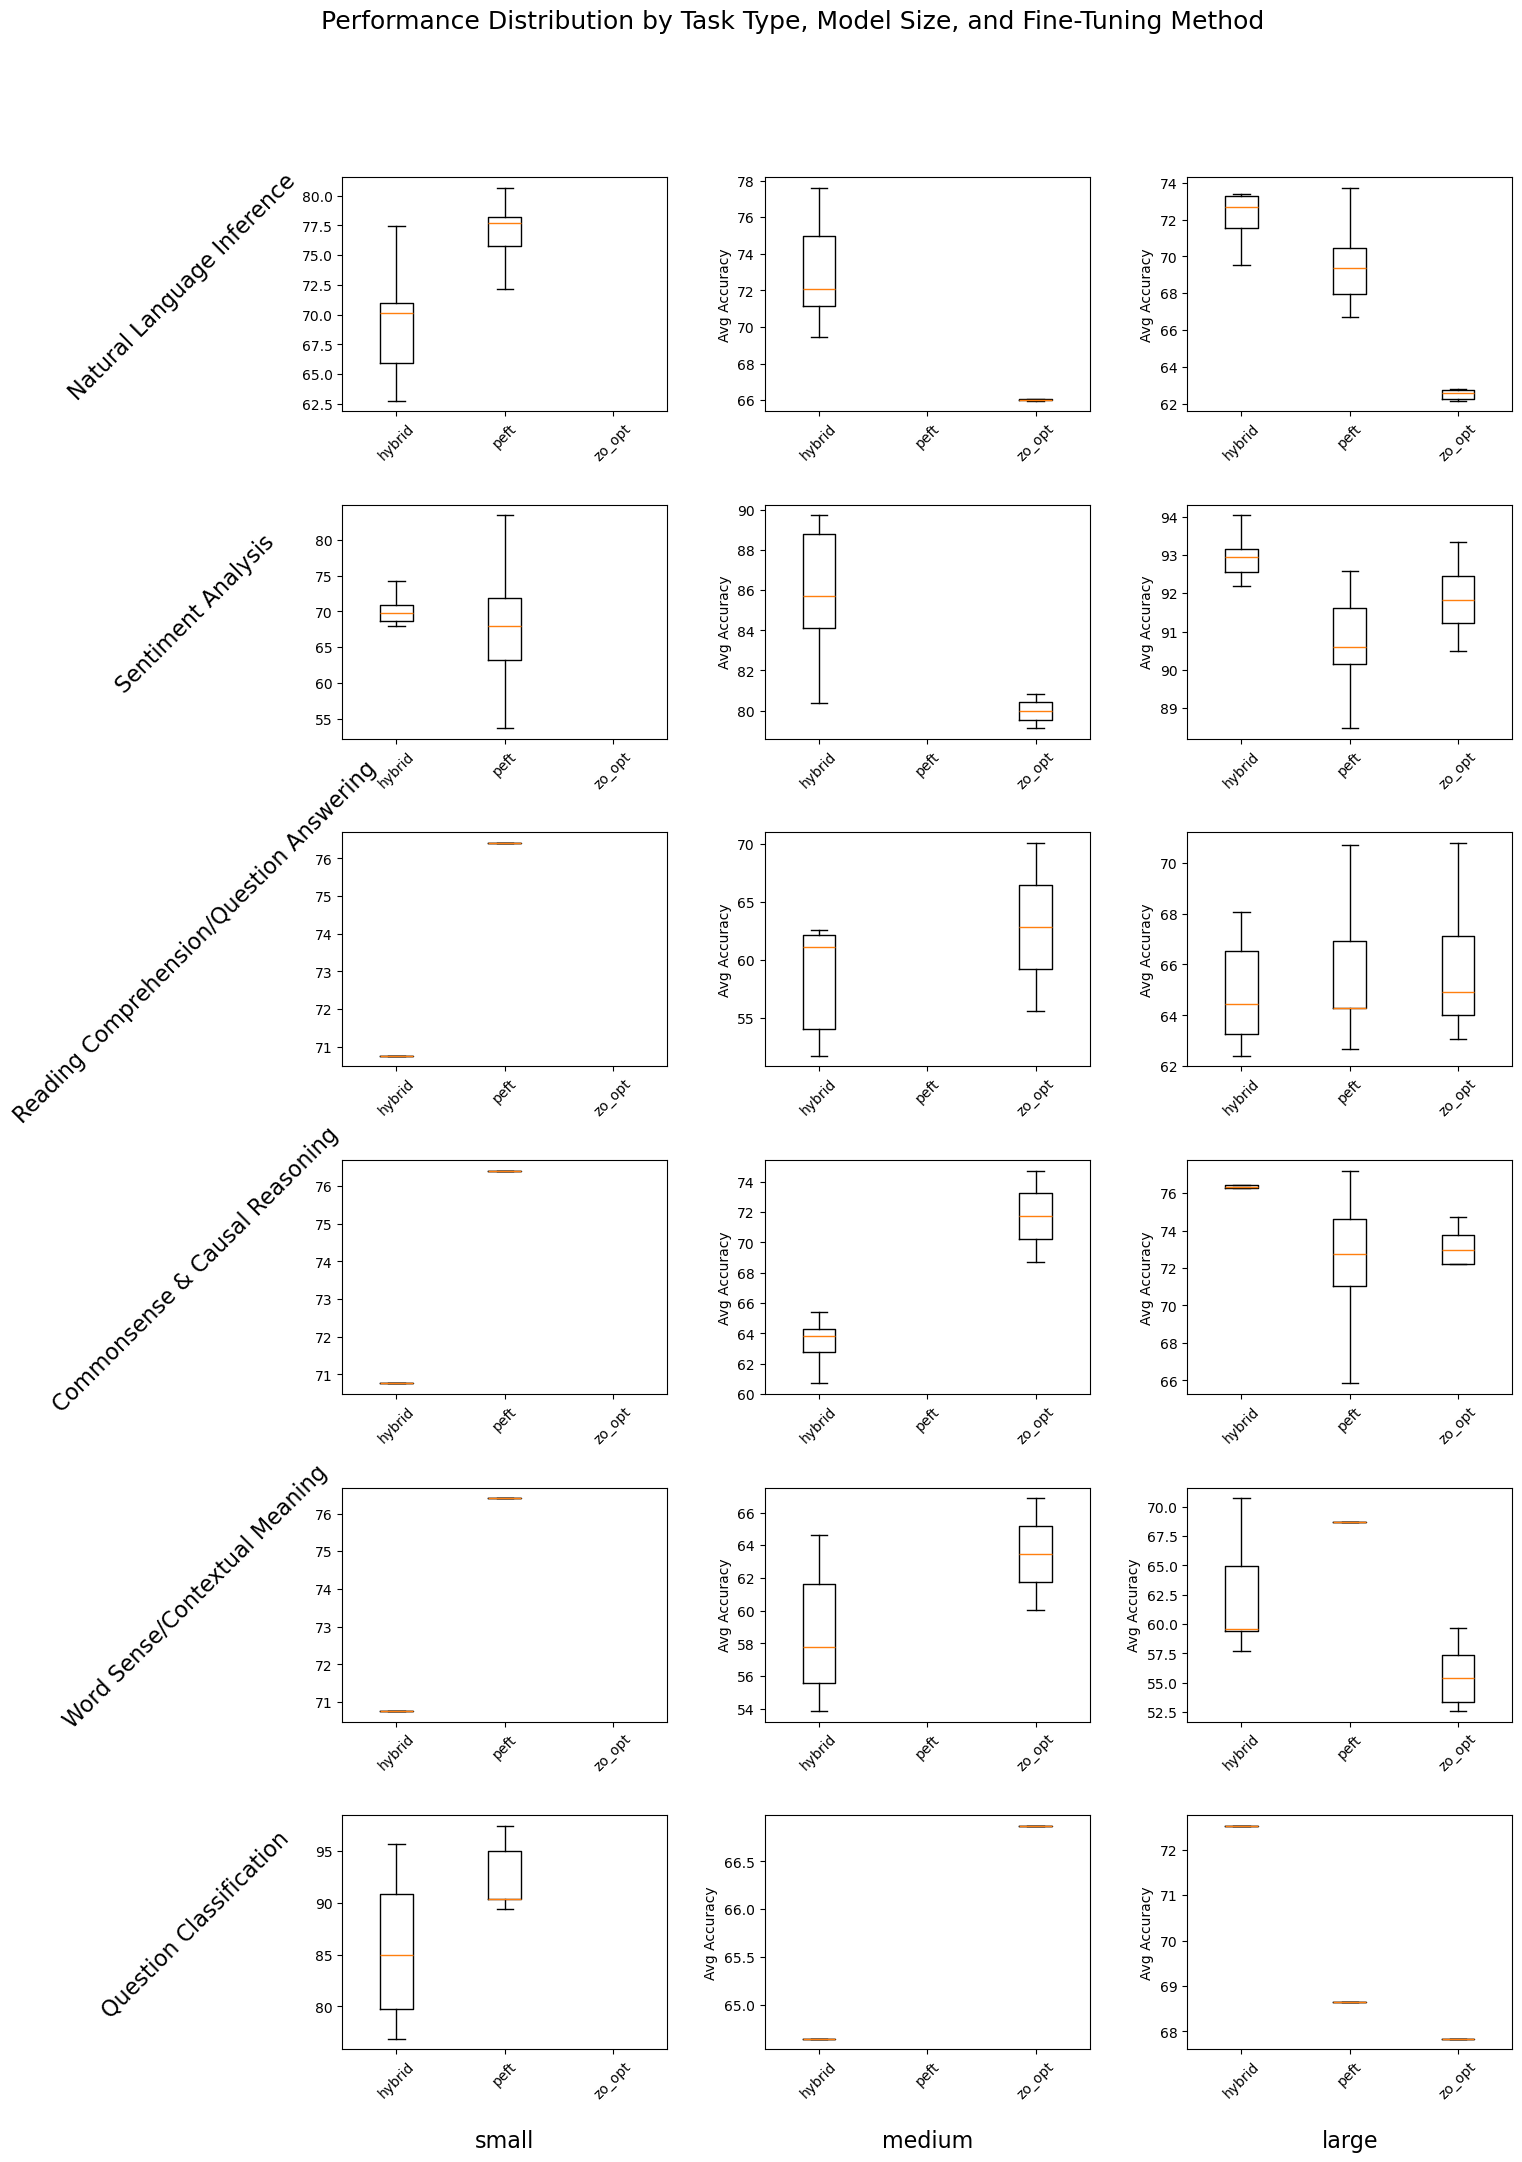

In [9]:
# Define the order for model sizes and task types for plotting
model_sizes = ['small', 'medium', 'large']
task_types = list(TASK_TYPE_TO_DATASET.keys())

# For consistent ordering across subplots, get all method types that appear in the DataFrame
all_methods = sorted(q1_df['method_type'].unique())

# Prepare the figure with 6 rows (task types) x 3 cols (model sizes)
fig, axes = plt.subplots(nrows=len(task_types), ncols=len(model_sizes), figsize=(18, 24), sharey=False)

# Adjust spacing to give room for the outer labels
fig.subplots_adjust(left=0.25, bottom=0.1, hspace=0.4, wspace=0.3)

# For each task type (row) and model size (col), create the boxplot
for i, task in enumerate(task_types):
    for j, msize in enumerate(model_sizes):
        ax = axes[i, j]
        # Filter the DataFrame for the current model size (using the 'model_type' column)
        df_sub = q1_df[q1_df['model_type'] == msize]
        
        # Prepare data for boxplot in a fixed order defined by all_methods.
        data_to_plot = []
        for method in all_methods:
            scores = df_sub[df_sub['method_type'] == method][task].dropna()
            # If no data is available, insert a placeholder (one NaN) so the position is reserved.
            if scores.empty:
                scores = [np.nan]
            data_to_plot.append(scores)
        
        # Plot the boxplot using the fixed method order.
        bp = ax.boxplot(data_to_plot, labels=all_methods, showfliers=False)
        
        # Optionally, adjust appearance of boxes with only placeholder data.
        for box, method in zip(bp['boxes'], all_methods):
            if np.isnan(np.nanmedian(data_to_plot[all_methods.index(method)])):
                box.set_color('gray')
        
        # Remove individual subplot titles.
        ax.set_title("")
        ax.set_ylabel("Avg Accuracy")
        ax.tick_params(axis='x', rotation=45)

# --- Add outer labels ---
# Add task type labels on the left side (one per row)
for i, task in enumerate(task_types):
    # Increase font size and adjust labelpad so they don't overlap with subplots
    axes[i, 0].set_ylabel(task, rotation=45, fontsize=16, labelpad=80)

# Add model size labels on the bottom (one per column)
for j, msize in enumerate(model_sizes):
    axes[-1, j].set_xlabel(msize, fontsize=16, labelpad=20)

plt.suptitle("Performance Distribution by Task Type, Model Size, and Fine-Tuning Method", fontsize=18, y=0.95)
plt.show()